According to Matt's epxeriance ([link](https://github.com/goodarzilab/khorms/blob/master/side_projects/COVID_DMSseq_library.ipynb)) I'm using this genome:

- https://www.ncbi.nlm.nih.gov/nuccore/MN908947?%3Fdb=nucleotide


# Peaks
<img src="igv/peaks.png" style="height:800px">

merge bed files and make `fasta`:

In [88]:
%%bash
# merge beds from all samples 
cat exomepeak/virus/*/peak.bed | grep -v '^ *#' | bed12ToBed6 | sort -k1,1 -k2,2n | \
mergeBed -i - -c 4 -o distinct | awk '{print $1"\t"$2"\t"$3"\t"$4"\t"".""\t""+"}' > merge_peaks.bed
# peaks with unique names 
awk -F "\t" '{OFS=FS}{$4=$4"_peak"}; cnt[$4]++{$4=$4"_"cnt[$4]} 1' merge_peaks.bed > merge_peaks.c.bed
# get peak sequences
bedtools getfasta -name -s -fi virus/coronavirus_2_isolate_Wuhan-Hu-1.fasta -bed \
merge_peaks.bed -split -fo merge_peaks.fa

write significant merged peaks in each samples into a text file:

In [88]:
%%bash
for f in exomepeak/virus/*/peak.bed; do 
    o=${f/peak.bed/sig_peak.txt}; 
#     echo Write $o; 
    cat $f | bed12ToBed6 | sort -k1,1 -k2,2n | bedtools intersect -wa -wb -a - -b merge_peaks.c.bed | \
    awk '{print $10"\t"$5}' > $o; 
done

In [89]:
%%bash
# for f in exomepeak/virus/*_FDR_0.025/peak.bed; do 
#     o=${f/_FDR_0.025\/peak/}; 
#     cp -v $f $o; 
# done
for f in exomepeak/virus/*_FDR_0.025/sig_peak.txt; do 
    o=${f/_FDR_0.025\/sig_peak/.sig}; 
    cp -v $f $o; 
done


'exomepeak/virus/COV00075_FDR_0.025/sig_peak.txt' -> 'exomepeak/virus/COV00075.sig.txt'
'exomepeak/virus/COV00084_FDR_0.025/sig_peak.txt' -> 'exomepeak/virus/COV00084.sig.txt'
'exomepeak/virus/COV00093_FDR_0.025/sig_peak.txt' -> 'exomepeak/virus/COV00093.sig.txt'
'exomepeak/virus/COV00106_FDR_0.025/sig_peak.txt' -> 'exomepeak/virus/COV00106.sig.txt'
'exomepeak/virus/COV00397_FDR_0.025/sig_peak.txt' -> 'exomepeak/virus/COV00397.sig.txt'
'exomepeak/virus/COV00413_FDR_0.025/sig_peak.txt' -> 'exomepeak/virus/COV00413.sig.txt'
'exomepeak/virus/COV00419_FDR_0.025/sig_peak.txt' -> 'exomepeak/virus/COV00419.sig.txt'
'exomepeak/virus/COV00422_FDR_0.025/sig_peak.txt' -> 'exomepeak/virus/COV00422.sig.txt'
'exomepeak/virus/COV00432_FDR_0.025/sig_peak.txt' -> 'exomepeak/virus/COV00432.sig.txt'
'exomepeak/virus/S0014_FDR_0.025/sig_peak.txt' -> 'exomepeak/virus/S0014.sig.txt'
'exomepeak/virus/S0026_FDR_0.025/sig_peak.txt' -> 'exomepeak/virus/S0026.sig.txt'
'exomepeak/virus/S0030_FDR_0.025/sig_peak.tx

count peak coverage in each sample (`bam` file) for downstream analysis:

In [90]:
%%bash
# peak count
for f in virus_bam/*bam; do
    base=`basename $f`;
    out=${base/.bam/.fc};
    bamToBed -i $f | intersectBed -split -s -wo -a - -b merge_peaks.c.bed | \
    cut -f10 | sort | uniq -c | awk '{ print $2 "\t" $1}' > virus_count/$out; 
done

# Motif analysis 

searching for `DRACH`, `RGAC`, `AAGAA` motifs in peak sequences: 

In [2]:
import re
import pandas as pd 
import numpy as np

DRACH = re.compile('[AGT][AG]AC[ACT]') 
RGAC = re.compile('[AG]GAC') 
AAGAA = re.compile('AAGAA') 

def read_fasta(path):
    file = open(path)
    lines = file.read().splitlines()
    ids = [s[1:] for s in lines if '>' in s]
    n = [i for i,s in enumerate(lines) if '>' in s]
    n.append(len(lines))
    sequences = [''.join(lines[i+1:j]) for i,j in zip(n[:-1],n[1:])]
    file.close()
    fa = dict(zip(ids, sequences))
    return fa

def find_motifs(sam):
    motifs = [[f.split('::')[0], 
         len(DRACH.findall(sam[f])), 
         len(RGAC.findall(sam[f])), 
         len(AAGAA.findall(sam[f])),
         ','.join(DRACH.findall(sam[f]) + RGAC.findall(sam[f]) + AAGAA.findall(sam[f]))
             ]
        for n, f in enumerate(sam)
              
    ]
    
    df = pd.DataFrame(motifs, columns=["loci","DRACH", "RGAC", "AAGAA","Sequence"])
    
    return df


peaks = read_fasta('merge_peaks.fa')
df = find_motifs(peaks)
df.replace(df.iloc[1,4], np.nan, inplace=True)

df.dropna(subset=["Sequence"], inplace=True)
df

,loci,DRACH,RGAC,AAGAA,Sequence
0,S,1,0,0,TGACT
2,S,9,2,0,"GGACT,GAACC,AGACT,TGACC,AAACA,AAACT,TAACT,AAAC..."
3,S,1,1,0,"AGACA,AGAC"
9,S,3,0,0,"AAACA,GAACA,TGACA"
10,S,2,2,0,"AGACT,AGACT,AGAC,AGAC"
14,S,1,0,2,"GAACT,AAGAA,AAGAA"
15,S,2,1,0,"TGACA,TGACC,AGAC"
17,ORF3a,2,0,0,"GAACT,TAACT"
19,ORF3a,1,0,0,TAACC
22,M,1,1,0,"AGACT,AGAC"


## internal control 
m6A+ m6A- [N6-Methyladenosine Enrichment Kit](https://international.neb.com/-/media/nebus/files/manuals/manuale1610.pdf?rev=c064d5e232414f709ef8bccee56f7687&hash=AAA94B8FDA043DD5A610E14686552B5E0209EA94)

$$\log_2\dfrac{RIP}{IN}$$


In [198]:
qPCR = pd.read_csv('first_dataset/RTqPCR.txt', sep='\t',index_col=0)

res = pd.read_csv('first_dataset/int_ctrl/result.txt', sep='\t')

# log2(RIP / IN)
pos  = [np.log2(res.loc[i+1,'pos']/ res.loc[i,'pos']) for i in list(range(0,res.shape[0],2))] 
neg  = [np.log2(res.loc[i+1,'neg']/ res.loc[i,'neg']) for i in list(range(0,res.shape[0],2))] 

Samples = [res.iloc[i,0].split('_')[0] for i in list(range(0,res.shape[0],2))] 

log2res = pd.DataFrame(index=Samples) 

qPCR['m6A_pos_ctrl'] = pos 
qPCR['m6A_neg_ctrl'] = neg 

qPCR 

,CoV-2 Ct,Number of peaks,m6A_pos_ctrl,m6A_neg_ctrl
Sample,,,,
S0008,19.6,10,3.683781,-2.090802
S0009,18.5,12,6.804162,-0.219748
S0014,16.3,37,2.141356,-3.560361
S0017,24.0,17,1.651047,-7.253435
S0025,22.1,0,6.203816,-1.010379
S0026,15.6,17,8.585372,2.581687
S0030,17.0,17,8.069236,1.410737
S0042,28.0,0,4.671282,-0.919416
S0057,26.7,3,8.344047,-1.969256


### Total number of reads:

virus

In [490]:
%%bash --err error
mkdir -p total
echo 'sample, reads' > total/virus.txt
for f in virus_bam/*bam;
	do 
    name=`basename $f`
    name=${name/.bam/}
    declare -i a=`samtools fastq $f | wc -l`
    read=$((a / 4))
    echo $name,$read >> total/virus.txt
done

human 

In [491]:
%%bash --err error
echo 'sample, reads' > total/human.txt
for f in */bam/*.bam; 
	do 
    name=`basename $f`
    name=${name/.bam/}
    declare -i a=`samtools fastq $f | wc -l`
    read=$((a / 4))
    echo $name,$read >> total/human.txt
done

ctrl m6A_neg

In [16]:
%%bash --err error
echo 'sample, reads' > total/m6A_neg.txt
for f in */int_ctrl/virus/m6A_neg/*bam; 
	do 
    name=`basename $f`
    name=${name/_S[0-9]*/}
    name=${name/.bam/}
    declare -i a=`samtools fastq $f | wc -l`
    read=$((a / 4))
    echo $name,$read >> total/m6A_neg.txt
done

ctrl m6A_pos

In [15]:
%%bash --err error
echo 'sample, reads' > total/m6A_pos.txt
for f in */int_ctrl/virus/m6A_pos/*bam; 
	do 
    name=`basename $f`
    name=${name/_S[0-9]*/}
    name=${name/.bam/}
    declare -i a=`samtools fastq $f | wc -l`
    read=$((a / 4))
    echo $name,$read >> total/m6A_pos.txt
done

In [30]:
aligned = ['human','virus','m6A_pos','m6A_neg']
total_df = pd.concat([pd.read_csv('total/'+a+'.txt', sep=',', index_col=0).sort_index() for a in aligned],axis=1)
total_df.columns = aligned

In [356]:
total_df.to_csv('total_reads.txt', sep='\t')

# Heatmap

In [496]:
import os
from scipy import stats 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import sklearn.preprocessing as pp

def read_data(samples, total=total_df, norm='l1', raw=False):
    all_samples = np.concatenate([[N+'_IN',N+'_RIP'] for N in samples]).tolist()
    # Read count files as dataframe
    df_list = [
        pd.read_csv('virus_count/' + file, header=None, sep='\t', index_col=0) 
        for file in [N+'.fc' for N in all_samples]
    ]
    # concatenate them together 
    big_df = pd.concat(df_list, axis=1)
    big_df.columns = all_samples
    # re-order peak names
    reorder = list(range(0,20)) + list(range(27,35)) + list(range(20,27))
    data = big_df.iloc[reorder,:]
    # names
    Peak_names = data.index.tolist()
    n_sam = len(all_samples)
    # normalize
    total = total_df.loc[all_samples,].sum(axis=1)

    total = np.array(total).T
    data = np.array(data) 
    if raw == True:
        raw_df = pd.DataFrame(data=data, columns=all_samples, index=Peak_names)
        return raw_df
    else:        
        # log2 (RIP in peak / RIP total) / (IN in peak / IN total)
        res = np.log2(
            (
                # RIP / RIP ctrl
                data [:,np.array(range(1,n_sam,2))] 
                /
                total[np.array(range(1,n_sam,2))]
            ) / (
                # IN / IN ctrl
                data [:,np.array(range(0,n_sam,2))] 
                /
                total[np.array(range(0,n_sam,2))]
            )
        )
        # normalization by samples
        if norm == None:
            res = res
        elif norm == 'min':
            res = pp.minmax_scale(res, feature_range=(0, 1), axis=1)
        elif norm == 'zscore':
            res = stats.zscore(res, axis=0, ddof=1)
        else:
            res = pp.normalize(res, axis=1, norm=norm)

        res_df = pd.DataFrame(data=res, columns=samples, index=Peak_names)
        return res_df

def add_border(plot,sig):
    i,j = sig
    plot.add_patch(Rectangle((i, j), 1, 1, fill=False, edgecolor='red', lw=5))

def draw_heatmap(data, sig_labels='',borders=False,save=False, name_it=''):
    heat_map = sns.heatmap(data,linewidth=2)
    # add borders 
    if borders is True:
        for sig in sig_labels: add_border (heat_map,sig)
    
    bottom, top = heat_map.get_ylim()
    heat_map.set_ylim(bottom + 0.5, top - 0.5)
    heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
    if save==True:
        plt.savefig(name_it + '.png')
        plt.savefig(name_it + '.pdf')
    else:
        plt.show()
    return heat_map

save raw counts 

In [497]:
raw_df = read_data([
    "S0008","S0009","S0014","S0017","S0025","S0026","S0030","S0042","S0057","S0085",
    "COV00075","COV00079","COV00084","COV00087","COV00093","COV00106",
    "COV00397","COV00413","COV00417","COV00419","COV00422","COV00432"
], raw=True)

raw_df.to_csv('raw_counts.txt', sep='\t')

In [498]:
Samples = ['S0014','S0026','S0030','S0085',
           'COV00075','COV00084','COV00093','COV00106','COV00397','COV00413','COV00419','COV00422','COV00432']

# final result
res_df = read_data(Samples, norm='zscore')
# names
Peak_names = res_df.index.tolist()
# res_df.to_csv('log2RIPvsIN.txt', sep='\t')

In [499]:
# significant peaks
sig_peaks = ['exomepeak/virus/' + N + '_FDR_0.025/sig_peak.txt' for N in Samples]
df_list = [pd.read_csv(file, header=None, sep='\t', index_col=0) for N, file in zip(Samples, sig_peaks)]

# significant peaks
sig_labels = []
for s, (name, df) in enumerate(zip(Samples,df_list)):
    peak = df.index.drop_duplicates(keep='first')
    sig_labels = sig_labels + [[n,s,] for n, p in enumerate(Peak_names) if p in peak]

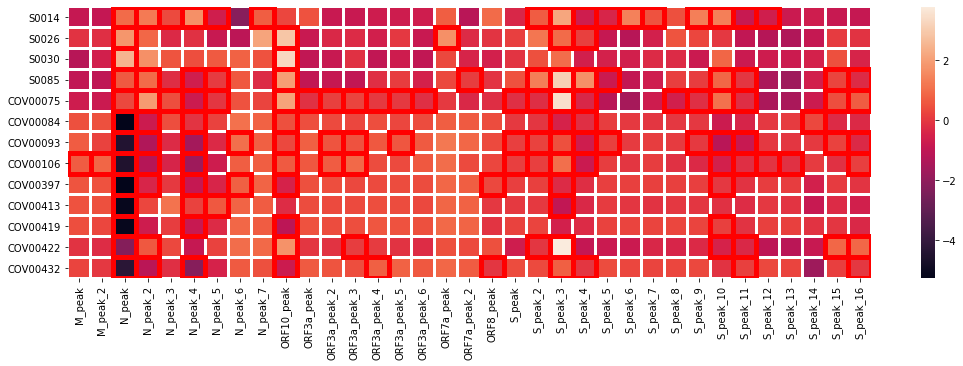

In [500]:
plt.figure(figsize=(18,5))
h = draw_heatmap(res_df.T, sig_labels, borders=True)

In [502]:
sig_df = res_df
sig_df.loc[:,:] = 1

for name, df in zip(Samples,df_list):
    peak = df.index.drop_duplicates(keep='first')
    pval = df.loc[~df.index.duplicated(keep='first')]
    s = sig_df.loc[peak,name].shape
    sig_df.loc[peak,name] = pval.to_numpy().reshape(s)
sig_df[sig_df == 0] = 1
# res_df.to_csv('log2RIPvsIN.txt', sep='\t')

significancy matrix. 

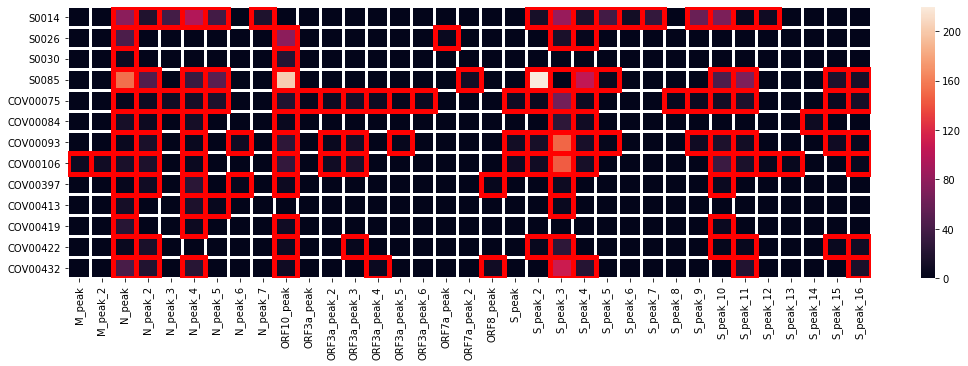

In [503]:
plt.figure(figsize=(18,5))
h = draw_heatmap(- np.log10(sig_df.T),sig_labels,borders=True)

In [504]:
sig_df.to_csv('peak_pval.txt', sep='\t')

binary map

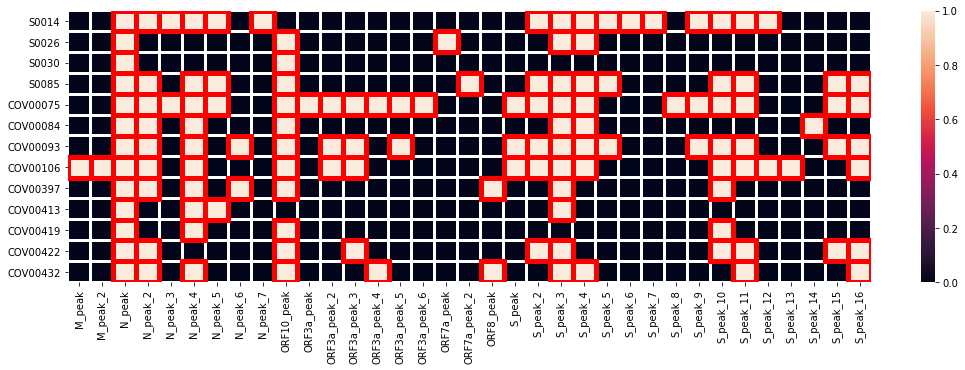

In [506]:
# binary peaks 
bin_df = res_df
bin_df.loc[:,:] = 0

for name, df in zip(Samples,df_list):
    peak = df.index.drop_duplicates(keep='first')
    bin_df.loc[peak,name] = 1
    
# res_df.to_csv('log2RIPvsIN.txt', sep='\t')

plt.figure(figsize=(18,5))
h = draw_heatmap(bin_df.T,sig_labels,borders=True, save=True, name_it='heatmap_binary')


visualize peaks:

https://rockefelleruniversity.github.io/RU_VisualizingGenomicsData/viz_course/Presentations/singlepage/Viz_part_1.html

In [ ]:
# %load_ext rpy2.ipython

In [483]:
# %%R
# library(dplyr)
# library(rtracklayer)
# library(GenomicFeatures)
# library(Gviz)

# GTF = 'virus/coronavirus_2_isolate_Wuhan-Hu-1.gff3'
# ### load genomes
# txdb <- makeTxDbFromGFF(GTF, organism=NA )
# genomeAxis <- GenomeAxisTrack()

In [484]:
# %%R
# columns(txdb)

In [485]:
# %%R
# keytypes(txdb)

In [486]:
# %%R
# gen = 'N'
# distance = 1000



# # S_peak <- DataTrack(merge_peaks,chromosome="chr",
# #                    name="S",
# #                    type="b")

In [487]:
# %%R
# seqlevels(txdb) <- 'chr'
# grtrack <- GeneRegionTrack(
#     txdb, 
#     chromosome = 'chr', name = "Gene Model",
# #     transcriptAnnotation = "symbol", 
#     background.panel = "#FFFEDB", background.title = "darkblue"
# )

In [488]:
# %%R
# merge_peaks <- import.bed("merge_peaks.c.bed")
# seqlevels(merge_peaks) <- 'chr'

In [489]:
# %%R
# plotTracks(c(S_peak,grtrack),
#            chromosome="chr1",
#            from=0,
#            to=100000,
#            type="b") #,pch=15,cex=2)


In [490]:
# %%R
# RIP_bw <- list.files(path='virus_bw/', pattern="RIP.bw")
# IN_bw <- list.files(path='virus_bw/', pattern="IN.bw")

# Names = gsub("_IN.bw", "", IN_bw)

In [491]:
# %%R
# function (sample, chr, gen, start, end) {
#     IN  <- paste(sample, 'IN', sep='_')
#     RIP <- paste(sample, 'RIP', sep='_')
    
#     IN_file  <- rtracklayer::import.bw(IN,  as="GRanges")
#     RIP_file <- rtracklayer::import.bw(RIP, as="GRanges")

    
#     GENE <- select(txdb,keys=gen, columns = "GENEID",keytype = "TXNAME")
#     GENE <- genes(txdb)[genes(txdb)$gene_id %in% GENE$GENEID]

#     start(GENE) <- start(GENE) - distance
#     end(GENE)   <- end(GENE) + distance

    
#     ots <- list()
#     #create data
#     dtrack_IN  <- DataTrack(
#         IN_file, chromosome=chr, from=start, to=end, 
#         name=paste(name, 'Input'), type=("hist")
#     )
    
#     dtrack_RIP <- DataTrack(
#         RIP_file, chromosome=chr, from=start, to=end, 
#         name=paste(name, 'm6A'),   type=("hist")
#         groups = factor(all_cond[d+1],levels = c(all_cond[d],all_cond[d+1]))
#     )

    
#     # Overlay IP and Input
#     displayPars(dtrack) <- list(groups = factor(all_cond[d],levels = c(all_cond[d],all_cond[d+1]) ),
#                                                 legend = TRUE)
#     ots <- append (ots, OverlayTrack(trackList=list(dtrack2, dtrack)))
# }

    
# }

In [492]:
# %%R
# ####
# ots <- list()
# for (d in seq(1, by = 2, len = length(all_cond)/2)){
#     #create data
#     dtrack <- DataTrack(range = get(paste('bedgraph_X', d,sep='')), genome = "mm10",
#                         from = , 
#                         to = ,
#                         chromosome = as.character(gene_stats$Chr[cc]))
#     dtrack2<- DataTrack(range = get(paste('bedgraph_X', d + 1,sep='')), genome = "mm10",
#                         from = gene_stats$Start[cc] - Z_out, to = gene_stats$End[cc] + Z_out,
#                         chromosome = as.character(gene_stats$Chr[cc]),
#                         groups = factor(all_cond[d+1],levels = c(all_cond[d],all_cond[d+1])))
#     # Overlay IP and Input
#     displayPars(dtrack) <- list(groups = factor(all_cond[d],levels = c(all_cond[d],all_cond[d+1]) ),
#                                                 legend = TRUE)
#     ots <- append (ots, OverlayTrack(trackList=list(dtrack2, dtrack)))
# }

# itrack <- IdeogramTrack(genome = 'mm10', chromosome = as.character(gene_stats$Chr[cc]))
# gtrack <- GenomeAxisTrack()
# plotTracks(append (list (itrack, gtrack), ots),
#            from = gene_stats$Start[cc] - Z_out, to = gene_stats$End[cc] + Z_out,
#            ylim = y_lim, type = "smooth")
# plotTracks(list (itrack, grtrack, gtrack),
#            from = gene_stats$Start[cc], to = gene_stats$End[cc], main = "Transcripts",
#            extend.left=l_scale, extend.right=r_scale)